<a href="https://colab.research.google.com/github/krarium/practice/blob/main/Quiz_GIS_Tutorials_with_OSMNX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로그램 설치

프로그램을 설치한뒤에, restart runtime을 실행한뒤에 2번째셀부터 이후 실행을 진행하시면 됩니다.

In [2]:
# !python -m pip uninstall numpy
# !pip install numpy==1.18
# !python -m pip uninstall matplotlib
!pip install osmnx
!pip install matplotlib
# !pip install descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

%matplotlib inline
# ox.config(log_console=True)
ox.__version__

'1.3.0'

# 도로 네트워크 작업해 보기

1. graph_from_place: 지역명
1. graph_from_address: 주소정보
1. graph_from_point: 위경도정보
1. graph_from_bbox: 동서남북좌표

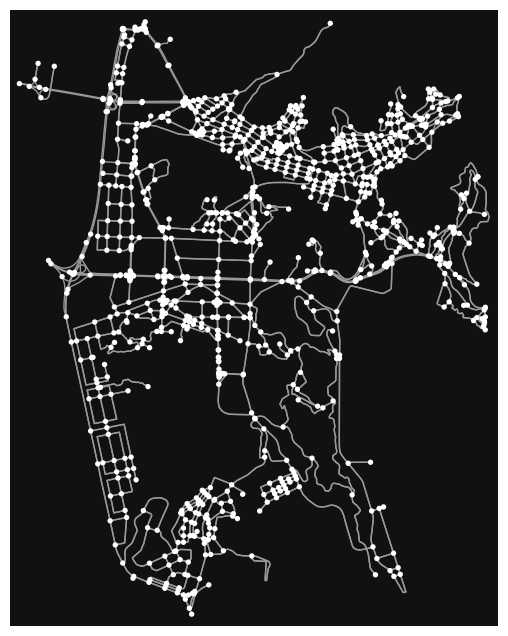

In [7]:
# download/model a street network for some city then visualize it
place = "saha-gu, Busan, Korea"
G = ox.graph_from_place(place, network_type="drive")
fig, ax = ox.plot_graph(G)

In [8]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

### *quiz1: 주소로부터 지도를 출력하시기 바랍니다


In [9]:
address = "Buk-gu, Busan, Korea" #@param {type:"string"}

# 도로의 속성 값에 따라서 다른 형태의 도로로 표시하기

아래 링크에서 다양한 도로정보를 살펴볼수가 있다.
https://wiki.openstreetmap.org/wiki/Key:highway


In [ ]:
# edge의 타입 따라서 도로에 대한 색깔 다르게 표시하기
hwy_colors = {'footway': 'blue',
              'residential': 'red',
              'cycleway': 'orange',
              'service': 'sienna',
              'living street': 'red',
              'secondary': 'green',
              'pedestrian': 'grey'}

In [ ]:
# 엣지를 탐색
def find_edges(G, hwys):
    edges = []
    for u, v, k, data in G.edges(keys=True, data='highway'):
        check1 = isinstance(data, str) and data not in hwys
        check2 = isinstance(data, list) and all([d not in hwys for d in data])
        if check1 or check2:
            edges.append((u, v, k))
    return set(edges)

In [ ]:
# hwy 이 정해지지 않은 경우는 black
G_tmp = G.copy()
G_tmp.remove_edges_from(G.edges - find_edges(G, hwy_colors.keys()))
m = ox.plot_graph_folium(G_tmp, popup_attribute='highway', weight=2, color='black')

# 지도 위에서 Hwy_colors에서 정해진 타입에 따라 추가적인 edge를 그림
for hwy, color in hwy_colors.items():
    G_tmp = G.copy()
    G_tmp.remove_edges_from(find_edges(G_tmp, [hwy]))
    if G_tmp.edges:
        m = ox.plot_graph_folium(G_tmp,
                                 graph_map=m,
                                 popup_attribute='highway',
                                 weight=2,
                                 color=color)

In [ ]:
m

### *quiz2: 도보(walk)을 다른 색깔과 함께 추가해보시오.

# 기본적인 도로네트워크

In [ ]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

37956386.39589514

In [ ]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 1029,
 'm': 2783,
 'k_avg': 5.40913508260447,
 'edge_length_total': 430568.97399999964,
 'edge_length_avg': 154.7139683794465,
 'streets_per_node_avg': 3.056365403304179,
 'streets_per_node_counts': {0: 0, 1: 97, 2: 1, 3: 687, 4: 235, 5: 9},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09426627793974733,
  2: 0.0009718172983479105,
  3: 0.6676384839650146,
  4: 0.22837706511175898,
  5: 0.008746355685131196},
 'intersection_count': 932,
 'street_length_total': 243812.93600000016,
 'street_segment_count': 1564,
 'street_length_avg': 155.8906240409208,
 'circuity_avg': 1.0889788575841688,
 'self_loop_proportion': 0.0019181585677749361,
 'clean_intersection_count': 743,
 'node_density_km': 27.11006230327772,
 'intersection_density_km': 24.554497635233076,
 'edge_density_km': 11343.782032068371,
 'street_density_km': 6423.502318080727,
 'clean_intersection_density_km': 19.575098436671862}

In [ ]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.save_graphml(G, filepath="./data/mynetwork.graphml")

# 도로의 중심성을 시각화

In [ ]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

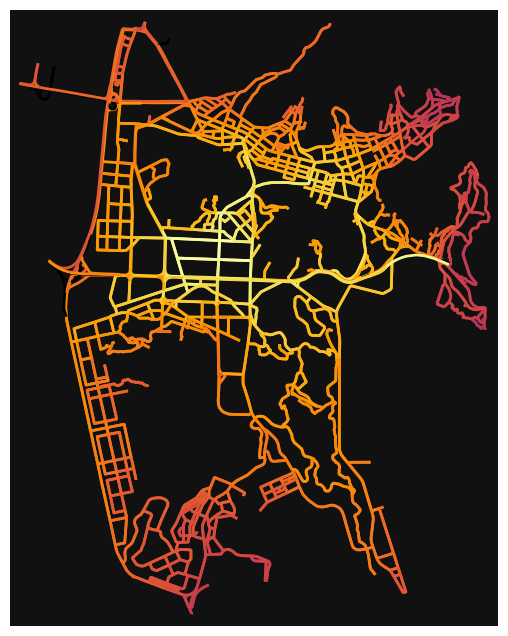

In [ ]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## quiz3: 부산의 다른 지역(번화가 중심성)을 진행하길 바랍니다. 이때 node_centrality와 차이가 있는지 확인해 보세요

# 경로(Routing) 확인

In [ ]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [ ]:
# get the nearest network nodes to two lat/lng points with the distance module 
orig = ox.distance.nearest_nodes(G, X=128.96755631796773, Y=35.11601594137444) 
dest = ox.distance.nearest_nodes(G, X=128.96517223758627, Y=35.046698756214056)

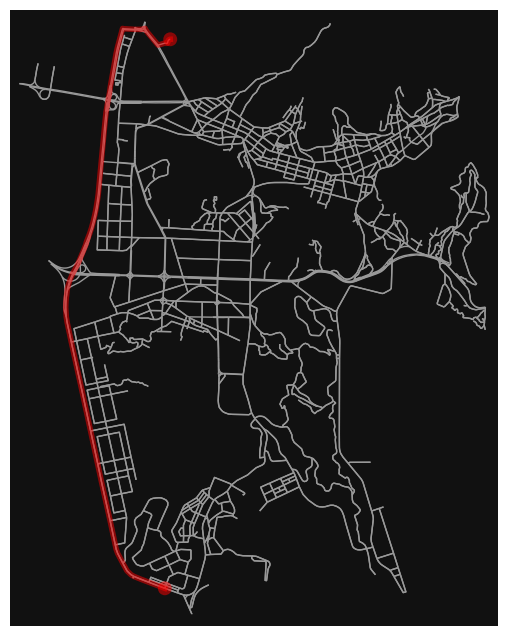

In [ ]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [ ]:
routes  = ox.k_shortest_paths(G, orig, dest, 3, weight="travel_time")
paths = [r for r in routes]

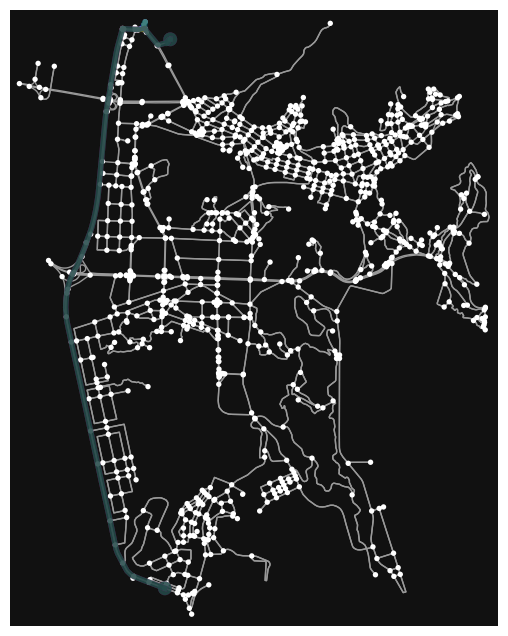

In [ ]:
# find the k-shortest paths between nodes, minimizing travel time, then plot it
fig, ax = ox.plot_graph_routes(G, paths, route_colors=['r','b','g'], route_linewidth=3)

In [ ]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
round(sum(edge_lengths))

8707

In [ ]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle_vec(orig_y, orig_x, dest_y, dest_x))

7255

### quiz5: networkx알고리즘 다양한 routing 알고리즘을 가지고 있습니다.
https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html
위 링크를 참고하여 다양한 routing 정보에 지도에 표현하길 바랍니다.

## 1. Fast nearest node/edge search with OSMnx

The nearest_nodes and nearest_edges functions take arrays of x and y (or lng/lat) coordinates and return the nearest node/edge to each.


In [ ]:
Gp = ox.project_graph(G)

In [ ]:
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.get_undirected(Gp), n=100)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

In [ ]:
# find each nearest node to several points, and optionally return distance
nodes, dists = ox.nearest_nodes(Gp, X, Y, return_dist=True)

In [ ]:
# or, find the nearest node to a single point
node = ox.nearest_nodes(Gp, X0, Y0)
node

4795892887

In [ ]:
# find each nearest edge to several points, and optionally return distance
edges, dists = ox.nearest_edges(Gp, X, Y, return_dist=True)

In [ ]:
# find the nearest edge to a single point
edge = ox.nearest_edges(Gp, X0, Y0)
edge

(6611505598, 4795892887, 0)

# 여정시간 계산 및 시각화

In [ ]:
!pip install descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

network_type: One of ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, or ‘all_private’.

In [ ]:
# configure the place, network type, trip times, and travel speed
address = "Hadan-dong, Saha-gu, Busan, Korea"
network_type = "walk"
trip_times = [5, 10, 15, 20, 25, 30]  # 분 단위의 여행시간, 5분거리내
travel_speed = 4.5  # 걷는 속도 (km/hour)

In [ ]:
# 위치에 따른 지도 가져오기
G = ox.graph_from_address( address, network_type=network_type)

In [ ]:
# 원하는 지점과 해당 지도에 대해서 그래프 
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
# x, y = gdf_nodes["geometry"].unary_union.centroid.xy # 지도 중심점 좌표
# 동아대학교의 위경도 좌표: lat -> 위도 x , 경도->lon y
x = 128.96817249950897
y = 35.11755694483541
center_node = ox.distance.nearest_nodes(G, x, y)
G = ox.project_graph(G)

In [ ]:
# 계산을 위한 edges에 속성값을 넣습니다.
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [ ]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

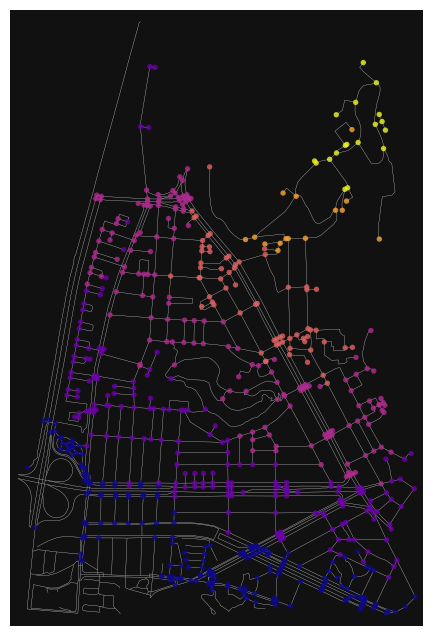

In [ ]:
# 등시성에 따라 노드에 색칠
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

In [ ]:
# 등시성의 polygon 구현
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

In [ ]:
"""
  CustomPolygonPath 
"""

from matplotlib.patches import PathPatch
from matplotlib.path import Path
from numpy import asarray, concatenate, ones

def CustomPolygonPath(polygon):
    """Constructs a compound matplotlib path from a Shapely or GeoJSON-like
    geometric object"""

    def coding(ob):
        # The codes will be all "LINETO" commands, except for "MOVETO"s at the
        # beginning of each subpath
        n = len(getattr(ob, 'coords', None) or ob)
        vals = ones(n, dtype=Path.code_type) * Path.LINETO
        vals[0] = Path.MOVETO
        return vals

    if hasattr(polygon, 'geom_type'):  # Shapely
        ptype = polygon.geom_type
        if ptype == 'Polygon':
            polygon = [Polygon(polygon)]
        elif ptype == 'MultiPolygon':
            polygon = [Polygon(p) for p in polygon]
        else:
            raise ValueError(
                "A polygon or multi-polygon representation is required")

    else:  # GeoJSON
        polygon = getattr(polygon, '__geo_interface__', polygon)
        ptype = polygon["type"]
        if ptype == 'Polygon':
            polygon = [Polygon(polygon)]
        elif ptype == 'MultiPolygon':
            polygon = [Polygon(p) for p in polygon['coordinates']]
        else:
            raise ValueError(
                "A polygon or multi-polygon representation is required")

    # convert `t.exterior` into `t.exterior.coords`
    # contributed by https://github.com/jsk0910
    vertices = concatenate([
        concatenate([asarray(t.exterior.coords)[:, :2]] +
                    [asarray(r)[:, :2] for r in t.interiors])
        for t in polygon])
    codes = concatenate([
        concatenate([coding(t.exterior)] +
                    [coding(r) for r in t.interiors]) for t in polygon])

    return Path(vertices, codes)

def CustomPolygonPatch(polygon, **kwargs):
    # 변경된 내용
    # 새로운 동작을 수행하는 코드
    return PathPatch(CustomPolygonPath(polygon), **kwargs)

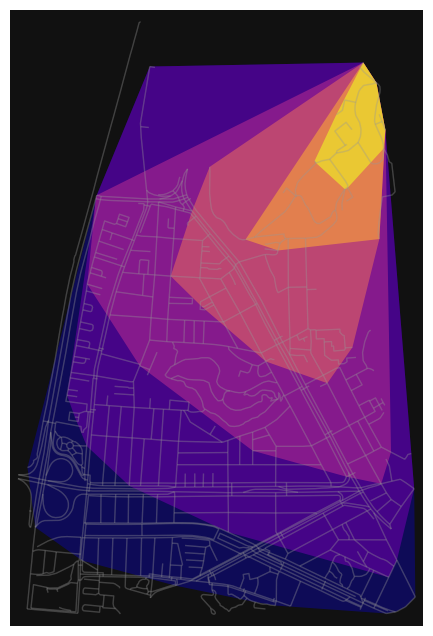

In [ ]:
# 등시성에 따른 네트워크를 표기
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = CustomPolygonPatch(polygon, fc=fc, ec="none", alpha=0.6, zorder=-1 )
    # patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

In [ ]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

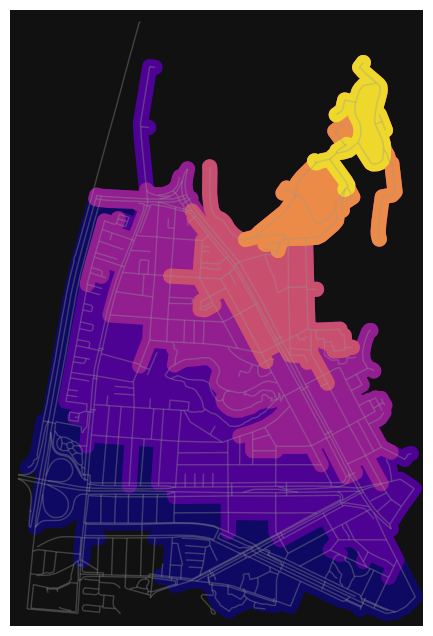

In [ ]:
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = CustomPolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)
plt.show()

# YOUR WORK: Hyperlocal 찾기
Definition: information oriented around a well-defined community with its primary focus directed toward the concerns of the population in that community.

슬세권이란 슬리퍼와 같은 편한 복장으로 각종 여가·편의시설을 이용할 수 있는 주거 권역을 가리킨다. 일상생활에 필요한 대부분을 인근에서 해결할 수 있어 주거 편의성이 높은 만큼 젊은 세대가 주 수요층인 오피스텔 시장에서 선호도가 높게 나타나고 있다.

출처 : 국토일보(http://www.ikld.kr)

주요 속성: 도보거리
A comparison of gait biomechanics of flip-flops,
sandals, barefoot and shoes
https://jfootankleres.biomedcentral.com/track/pdf/10.1186/1757-1146-6-45.pdf